#### On toymodules.
Compared to the sgan code, the toymodules dont have any type of pooling, i.e. the network does not know that agents are together in a scene. A very big __difference__ of __sgan__ and __toymodules__ to our __initial way to implement the modules__ is that the generator only __generates displacements__ and __loss is computed on displacements__.

#### Other remarks.
I renamed some variables for clarifying things:

- obs_taj -> xy_in
- obs_traj_rel -> dxdy_in
- pred_taj -> xy_out
- pred_traj_rel -> dxdy_out
- obs_len -> in_len
- pred_len -> out_len

Moreover, I commented some parts in sgan code and our code starting with "Important" and "Questions". In Pycharm you can go to Settings -> TODO and then create new keywords as TODO that will be highlighted in different colors. Thats super nice.

In [1]:
%load_ext autoreload
%autoreload 2
%env CUDA_VISIBLE_DEVICES=0
import numpy as np
import torch
from torch import nn
from mapsgan import Solver, ToyGenerator, ToyDiscriminator, data_loader
import mapsgan.experiments as experiments
from mapsgan.evaluation import Visualization
from mapsgan.utils import smooth_data
import matplotlib.pyplot as plt
torch.cuda.is_available()

env: CUDA_VISIBLE_DEVICES=0


True

In [2]:
experiment = experiments.ETH() # we store filepaths and arguments in here
dataset, trainloader = data_loader(in_len=8, out_len=12, batch_size=64, num_workers=1, path=experiment.test_dir,)
_, testloader = data_loader(in_len=8, out_len=12, batch_size=1, num_workers=1, path=experiment.test_dir,)

In [20]:
generator = ToyGenerator(in_len=8, out_len=12, noise_dim=(10,), decoder_h_dim=74)
discriminator = ToyDiscriminator()

In [21]:
solver = Solver(generator, discriminator,  # pls read the code and docstrings to get the idea
                optims_args={'generator': {'lr': 1e-2}, 'discriminator': {'lr': 1e-2}})

In [25]:
solver.train(trainloader, epochs = 1000, checkpoint_every=10, print_every=10, val_every=10, testloader=testloader, steps = {'generator': 1, 'discriminator': 1})

Training new model

       Generator Losses    Discriminator Losses
Epochs G_BCE     G_L1      D_Real    D_Fake    
Training new model

       Generator Losses    Discriminator Losses
Epochs G_BCE     G_L1      D_Real    D_Fake    
1000   0.675     0.102     0.667     0.707     
1000   0.675     0.102     0.667     0.707     
990    0.684     0.111     0.670     0.705     
990    0.684     0.111     0.670     0.705     
980    0.691     0.110     0.665     0.702     
970    0.693     0.108     0.677     0.696     
970    0.693     0.108     0.677     0.696     
960    0.684     0.104     0.637     0.701     
950    0.664     0.122     0.598     0.771     
950    0.664     0.122     0.598     0.771     
940    0.687     0.123     0.631     0.698     
930    0.690     0.101     0.616     0.694     
920    0.691     0.103     0.645     0.694     
920    0.691     0.103     0.645     0.694     
910    0.681     0.108     0.649     0.734     
910    0.681     0.108     0.649     0.734     


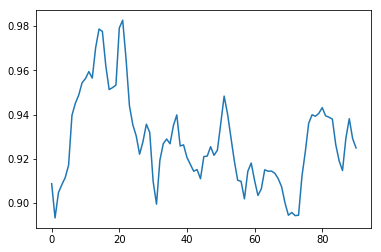

In [33]:
plt.plot(smooth_data(solver.train_loss_history['validation']['diversity']['scene_cos'], 10))

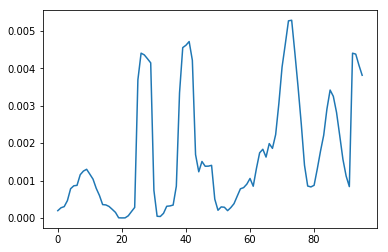

In [32]:
plt.plot(smooth_data(solver.train_loss_history['validation']['diversity']['agent_interp'], 5))

### Visualize things.
As we talked about, I implemented a simple plotting class that is supposed to integrate with the rest. E.g. vis.loss takes the dictionary 'solver.train_loss_history' of the solver object to plot all losses.
- For everything that you would like to visualize, think about how we could implement it in the class Visualization.

#### Losses

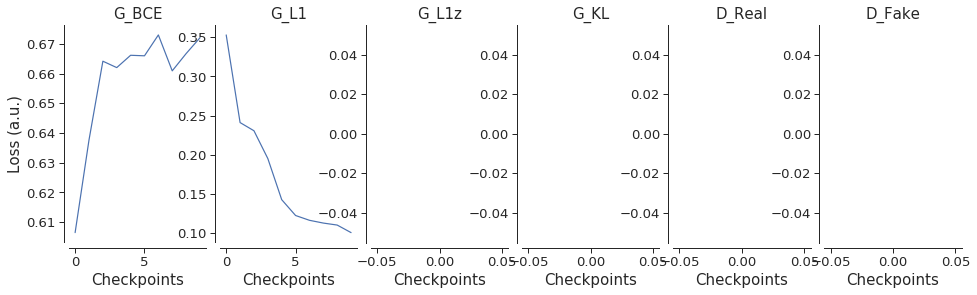

In [10]:
vis = Visualization()
vis.loss(solver.train_loss_history['validation'])

#### Trajectories

In [9]:
# get trajectories, dimensions are (scenes, sequence (in and pred), seq_len, num_agents, coordinates)
output = solver.test(trainloader)

In [10]:
ymin = np.min([np.min(seq[:, :, 1]) for scene in output for seq in scene])
ymax = np.max([np.max(seq[:, :, 1]) for scene in output for seq in scene])
xmin = np.min([np.min(seq[:, :, 0]) for scene in output for seq in scene])
xmax = np.max([np.max(seq[:, :, 0]) for scene in output for seq in scene])
plt.plot(output[0][0][:, 1, 0], output[0][0][:, 1, 1])
plt.plot(output[0][1][:, 1, 0], output[0][1][:, 1, 1])
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)

TypeError: string indices must be integers

#### other

In [13]:
# get gt vs pred, dimensions are (scenes, sequence (out and pred), seq_len, num_agents, coordinates)
output = solver.test(trainloader)